In [2]:
#Load the correct packages
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from time import time
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc

First we define our U-net from the following classes DoubleConv, Downsample, Upsample and UNet. The DoubleConv corresponds to the blue arrows from the UNet figure, Downsample the red arrows and upsample the green arrows. The grey arrows are incorporated into the forward pass in the UNet class. 

In [3]:
class DoubleConv(nn.Module):
    # This is a class that defines a double convolutional layer,
    # which in the U-net structure corresponds to the blue arrows.
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Dropout2d(p = dropout_prob),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.is_residual = in_channels == out_channels
    def forward(self, x):
        if self.is_residual:
            return x + self.conv_op(x)
        else:
            return self.conv_op(x)
    
class DownSample(nn.Module):
    # This is a class that defines a downsampling layer,
    # which in the figure corresponds to the red arrows.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p
    
class UpSample(nn.Module):
    # This is a class that defines an upsampling layer,
    # which in the U-net figure corresponds to the green arrows.
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes,dropout_prob=0.2):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottleneck = nn.Sequential(
            DoubleConv(512, 1024, dropout_prob=dropout_prob),
            nn.Dropout2d(p=dropout_prob)  # Additional bottleneck dropout
        )
        
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        #in the forward pass of the U-net save the hidden states as p1, p2, p3, p4,
        #these will be concatenated in the upsample layers corresponding to the grey arrows. 
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottleneck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)
        out = self.out(up_4)
        
        return self.sigmoid(out)

class CellDataset(Dataset):
    # This is a class that defines a dataset for our data.
    # It loads the preprossed data and returns the images and masks.
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.data = sorted([root_path+i for i in os.listdir(root_path)])
        else:
            self.data = sorted([root_path+i for i in os.listdir(root_path)])

    def __getitem__(self, index):
        data = np.load(self.data[index])
        img = data[:-1,:,:]
        mask = data[-1,:,:]
        
        return torch.tensor(img) / 255, torch.tensor(mask).unsqueeze(0)
    
    def __len__(self):
        return len(self.data)

# This function is used to move all the loaded data to the device that we trai on. 
def get_some_images(dataloader, device, n=1):
    """ Load n images from dataloader to device
    
        Returns a list of the images
    """
    Xs, ys = [], []
    i = 1
    for X, y in dataloader:
        X_temp = X.float().to(device)
        y_temp = y.float().to(device)
        Xs.append(X_temp)
        ys.append(y_temp)
        
        i += 1
        if i > n:
            break
    return Xs, ys


Showing some sample model predictions on test data that was not seen in training:

In [ ]:
# Selecting the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

#Loading the model
model = UNet(11, 1)
model.load_state_dict(torch.load('model_final.pth'))
# model.load_state_dict(torch.load('model_final.pth', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()


Device: cpu


UNet(
  (sigmoid): Sigmoid()
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.2,

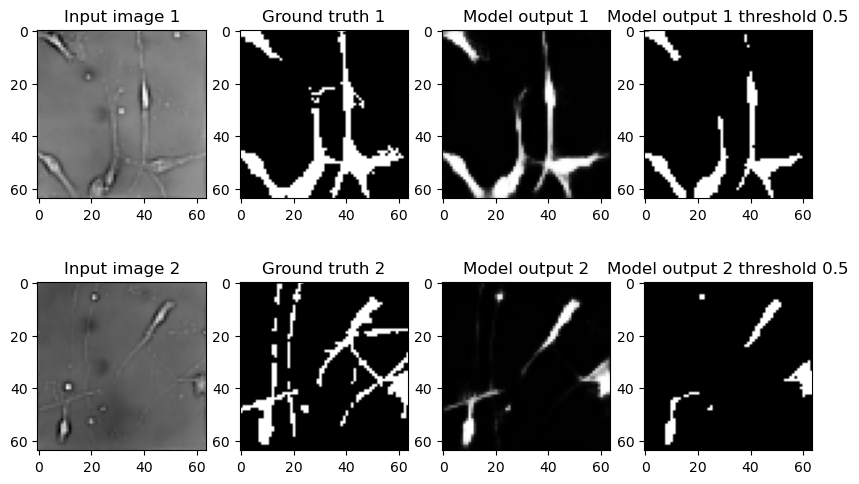

In [10]:
# Test on image we did not train on
test_image_1 = np.load('Test_images/well1_s01.npy')
img_1 = torch.tensor(test_image_1[:-1,:,:]/255).unsqueeze(0).float().to(device)
mask_1 = torch.tensor((test_image_1[-1,:,:]>0.5)*1).unsqueeze(0).float().to(device)

test_image_2 = np.load('Test_images/well1_s02.npy')
img_2 = torch.tensor(test_image_2[:-1,:,:]/255).unsqueeze(0).float().to(device)
mask_2 = torch.tensor((test_image_2[-1,:,:]>0.5)*1).unsqueeze(0).float().to(device)

model_out_1 = model(img_1).detach().cpu().numpy()
model_out_2 = model(img_2).detach().cpu().numpy()
fig,ax = plt.subplots(2,4, figsize=(10,6))
ax[0,0].imshow(img_1[0,0].cpu().numpy().squeeze(), cmap='gray')
ax[0,0].set_title('Input image 1')
ax[0,1].imshow(mask_1.cpu().numpy().squeeze(), cmap='gray')
ax[0,1].set_title('Ground truth 1')
ax[0,2].imshow(model_out_1.squeeze(), cmap='gray')
ax[0,3].set_title('Model output 1 threshold 0.5')
ax[0,3].imshow(model_out_1.squeeze()>0.5, cmap='gray')
ax[0,2].set_title('Model output 1')
ax[1,0].imshow(img_2[0,0].cpu().numpy().squeeze(), cmap='gray')
ax[1,0].set_title('Input image 2')
ax[1,1].imshow(mask_2.cpu().numpy().squeeze(), cmap='gray')
ax[1,1].set_title('Ground truth 2')
ax[1,2].imshow(model_out_2.squeeze(), cmap='gray')
ax[1,3].set_title('Model output 2 threshold 0.5')
ax[1,3].imshow(model_out_2.squeeze()>0.5, cmap='gray')
ax[1,2].set_title('Model output 2')
plt.show()